# <span style="color:#845EC2">**Results and Analysis :** One word transcriptions </span> 

Focus on <b><span style="color:#D65DB1"> version 1 </span></b> for the transcription.

### <b><span style="color:#FF6F91"> Library Imports </span>

In [2]:
# Library imports
import sys      
script_directory = '../'
sys.path.append(script_directory) # Putting the script directory into the system path by ChatGPT
import self_made_functions as smf
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
from   textwrap import wrap # From ChatGPT
import seaborn as sns
import pandas as pd
import numpy as np
import jiwer
import os

2024-07-07 12:45:37.945967: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-07-07 12:45:39.076279: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


### <b><span style="color:#FF9671"> Data initialization  </span>

In [3]:
df_assessment, wv_path = smf.get_correct_df()

# Make a new directory for resaved files 
results_dir = '../Transcriptions/Results'
if not os.path.exists(results_dir):
    os.makedirs(results_dir)
    print(f"Directory {results_dir} created")

# Read empty transcriptions
empty_transcriptions = pd.read_csv('../Transcriptions/true_empty_transcriptions_v1.csv')

# Transcription directory information
transcription_dir = '../Transcriptions'
lst_csv = os.listdir(transcription_dir)
# lst_csv = [file for file in lst_csv if file.startswith('tran') & file.endswith('v1.csv')] # The v1 transcribed files
lst_csv = [file for file in lst_csv if file.startswith('true_tran') & file.endswith('v1.csv')] # The v1 transcribed files



In [4]:
# Sort the list by model name
test_for_models = ['tiny', 'nb-whisper-tiny', 'nb-whisper-tiny-verbatim',
                    'base', 'nb-whisper-base', 'nb-whisper-base-verbatim',
                    'medium', 'nb-whisper-medium', 'nb-whisper-medium-verbatim']
lst_csv = sorted(lst_csv, key=lambda x: test_for_models.index(x.split('_')[-2]))

#### <b><span style="color:#FF6F91"> Save missing information </span></b>

 The transcription files are changed and re saved.

The <b><span style="color:#ff9671">empty-transcriptions</span></b> are added to the transcriptions.

The <b><span style="color:#ff9671">Phonetic Error Ratio (PER)</span></b> is calculated. 

A <b><span style="color:#ff9671">ID column</span></b> is added, and all the colum names are <b><span style="color:#ff9671">renamed</span></b> and organized.


A column for the <b><span style="color:#ff9671">model name</span></b> is also added. 

In [5]:
def resave_transcription_df(bool:True):
    lst_path = [os.path.join(transcription_dir, file) for file in lst_csv]

    # Iterate through the CSV files to add what is missing
    for path in lst_path:    
        # Read transcriped files
        df_csv = pd.read_csv(path)
        print(f"Reading {path}")

        # For old transcriptions ------
        # df_csv = df_csv.drop(['CER Output',"CER Score"], axis=1) # axis = 1 : drops column, = 0 : drops row 
        # # Fix the CER column - For comparison
        # df_csv['CER (Character Error Rate)'] = df_csv.apply(lambda x: jiwer.cer(x['Word'], x['Transcribed']), axis=1)
        # ------------------------------
        
        # Add a column with the striped transcription and its corresponding CER.
        # This is interning regarding the performance of the verbatim model.
        # All transcriptions, excluding the empty transcriptions, are striped for all models, including verbatim.
        df_csv['transcribed_word_striped'] = df_csv['Transcribed'].apply(
            lambda x: x.strip().lower().replace(".", "").replace(",", "").replace("!", "").replace("?", "") 
            if isinstance(x, str) else x)      
        df_csv['striped_CER'] = df_csv.apply(lambda x: jiwer.cer(x['Word'], x['transcribed_word_striped']), axis=1)
        # print(df_csv[df_csv['File name']=='a01_sykkel.wav'])
        
        # Add model name
        model_name = path.split('_')[-2]
        df_csv["model_name"] = model_name
        
        # # Change names - for old transcriptions ------
        # df_csv = df_csv.rename(columns={"File name": "file_name",
        #                             "CER (Character Error Rate)": "CER", # Character Error Rate (CER)
        #                             "Word": "target_word", 
        #                             "Transcribed": "transcribed_word", 
        #                             "OG Score": "global_score"})
        # -----------------------------------------------
        df_csv = df_csv.rename(columns={"File name": "file_name",
                                    "CER (Character Error Rate)": "CER", # Character Error Rate (CER)
                                    "Word": "target_word", 
                                    "Transcribed": "transcribed_word", 
                                    "CER Score": "global_score"})
        
        for i, row in df_csv.iterrows():
            pron_lst = df_assessment[df_assessment['File name'] == row["file_name"]].pronScores.values[0].split(' ')
            pron_count = pron_lst.count('0')
            per = pron_count/len(pron_lst)
            df_csv.loc[i, "PER"] = per # Phonetic Error Rate (PER)
        
        df_csv = pd.concat([df_csv, empty_transcriptions[empty_transcriptions['model_name']==model_name]], ignore_index=True)
        df_csv = df_csv.reset_index(drop=True)
        # print(df_csv[df_csv['file_name']=='a01_sykkel.wav'])
        
        if len(df_csv.model_name.unique()) > 1:
            print(f"Error: {path} has more than one model name")
            break
        
        # Add ID column
        df_csv["id"] = df_csv["file_name"].apply(lambda x: x.split('_')[0])
        df_csv = df_csv.sort_values(by=['id'])
        
        # print(df_csv.columns)    
        # Reorder column names
        reorder_column = ["id", "global_score", 
                        "target_word", "PER", 
                        "transcribed_word", "CER", 
                        "transcribed_word_striped", "striped_CER",
                        "file_name", "model_name"]
        
        df_csv = df_csv[reorder_column]
        # print(df_csv.columns)   

        if bool:
            # Save the file
            csv_name = path.split('/')[-1]
            df_csv.to_csv(os.path.join(results_dir, csv_name), index=False)    

# resave_transcription_df(True)

### **<span style="color:#FFC75F"> BOX PLOT &nbsp;:&nbsp; </span>**
#### <span style="color:#F9F871">  Every *model* compared &nbsp;:&nbsp; CER vs. PER for <b>Native</b>, <b>Non Native</b> and <b>All</b> </span>

Create directory to save the box plots &nbsp; : &nbsp; <span style="color:#FF6F91"> *./BoxPlots/Model_CER*</i></span>

In [6]:
save_dir_box_cer = '../Transcriptions/Results/BoxPlots/Model_CER'
if not os.path.exists(save_dir_box_cer):
    os.makedirs(save_dir_box_cer)
    print(f"Directory {save_dir_box_cer} created")

Make a fuction that works for both all, native and non-native speakers

##### **<span style="color:#FF9671"> Giga Matrix**

In [7]:
# Could also use "lst_csv", but safer to remake the list
lst_csv_re_saved = os.listdir(results_dir)
# lst_csv_re_saved = [file for file in lst_csv_re_saved if file.startswith('tran') & file.endswith('v1.csv')] 
lst_csv_re_saved = [file for file in lst_csv_re_saved if file.startswith('true_tran') & file.endswith('v1.csv')] 
lst_csv_re_saved = sorted(lst_csv_re_saved, key=lambda x: test_for_models.index(x.split('_')[-2]))
lst_path = [os.path.join(results_dir, file) for file in lst_csv_re_saved] 
ggm = pd.DataFrame()
# Iterate through the CSV files to add what is missing
for path in lst_path:
    # print(f"Reading {path}")
    df_csv = pd.read_csv(path)
    ggm = pd.concat([ggm, df_csv], ignore_index=True)
ggm = ggm.reset_index(drop=True)

##### **<span style="color:#FFC75F"> Fix model names for Giga Matrix**
Fix what the model names in the box plot shows, and that the PER can be one of the boxes in teh box plot.

In [8]:
def fix_model_names(gigamind:pd.DataFrame, cer_value:str = 'CER'):
    # Remove "whisper" from the model name
    gigamind['model_name'] = gigamind['model_name'].apply(lambda x: x.replace('nb-whisper', 'NNL'))

    # Get Capitalized model names fro tiny, base and medium
    gigamind['model_name'] = gigamind['model_name'].apply(lambda x: x.capitalize() if not x.startswith('NNL') or x.startswith('P') else x)

    # Add PER to model names so it gets its own column
    new_per = gigamind[gigamind.model_name == 'Tiny'][['PER', 'file_name', 'global_score']].copy()
    new_per = new_per.rename(columns={"PER": f"{cer_value}"})
    new_per['model_name'] = 'Phone Error Rate (PER)'

    gigamind = pd.concat([new_per, gigamind], ignore_index=True)
    return gigamind

##### **<span style="color:#F9F871"> BOX PLOT function for all models comparing PER and CER**

In [9]:
def box_plots_model(giga_df:pd.DataFrame, save_dir:str, title:str, cer_value:str = 'CER', cer_name:str = 'CER', 
                    extended:int=2.1, max_verbatim:int = 1.5, save:bool = True):

    fig, ax = plt.subplots(1, 1, figsize=(12, 6))
    
    # ---------- Color palette  ---------- #
    palette = ['#FFC75F', # PER color
        '#A8BB5C', '#20887A', '#2F4858', # Model colors       
        '#A8BB5C', '#20887A', '#2F4858',          
        '#A8BB5C', '#20887A', '#2F4858'
        ]
    
    # ---------- Horizontal lines ---------- #
    # Line for the maximum cer_value for the medium-verbaitm
    max_cer_model1 = giga_df[(giga_df['model_name'] == 'NNL-medium-verbatim') & 
                            (giga_df[cer_value] >= 0) & 
                            (giga_df[cer_value] <= max_verbatim)][cer_value].max()
    ax.axhline(max_cer_model1, color='#B5AA99', linestyle='--')
    
    # Line for the median value
    median_value = giga_df[giga_df['model_name'] == 'Phone Error Rate (PER)'][cer_value].median()
    ax.axhline(median_value, color='#C1554D', linestyle='--')
    
    # Add to make space for the legend
    ax.axhline(extended, color='#ffffff', linestyle='--')
    
    #  ----------  Boxplot ---------- #
    sns.boxplot(x='model_name', y=cer_value, hue='model_name', data=giga_df, ax=ax, showfliers=False, palette=palette)

    #  ---------- Model legend box  ---------- #  (Custom legends found by ChatGPT) 
    chosen_colors = ['#A8BB5C', '#20887A', '#2F4858']
    chosen_names = ['OpenAI', 'Norwegian National Library (NNL)', 'NNL-Verbatim']
    legend_patches = [mpatches.Patch(color=color, label=name) for name, color in zip(chosen_names, chosen_colors)]

    # Add legend with custom settings
    # legend = ax.legend(handles=legend_patches, loc='upper right', frameon=True, shadow=True, title='Models')
    # legend.get_frame().set_facecolor('#f0eeeb')  # Background color
    # legend.get_title().set_fontsize('12')  # Title font size
    
    legend = ax.legend(handles=legend_patches, loc='upper right', frameon=False, shadow=False)
    for text in legend.get_texts():
        text.set_fontsize('14')  # Legend text font size
    
    #  ---------- Title and labels ---------- #
    plt.title(f'PER compared to CER  - {title} - {cer_name}', fontsize=21)
    plt.xlabel('Target words  &  Model names', fontsize=17)
    plt.ylabel(f'PER & CER', fontsize=17)
    
    #  ---------- Wrap x-axis ---------- # (Wrap method found by ChatGPT) 
    # model_names = [ '\n'.join(wrap(label, 9)) for label in giga_df['model_name'].unique() ]
    model_names = [
    '\n'.join(wrap(label, 8)) if label.endswith(("(PER)")) or label.startswith(("NNL")) else label 
    for label in giga_df['model_name'].unique()]
    
    plt.xticks(ticks=range(len(model_names)), labels=model_names, fontsize=15)
    plt.yticks(fontsize=16)
    
    # ------- Save or Show ---------- #
    plt.tight_layout()
    if save:
        plt.savefig(save_dir)
        plt.close()
    else: 
        plt.show()  

##### <b><span style="color:#FF6F91"> Box plot for all models, all data, native and non-native</span></b> Unmodified (U) *NOT STRIPED (NS)*

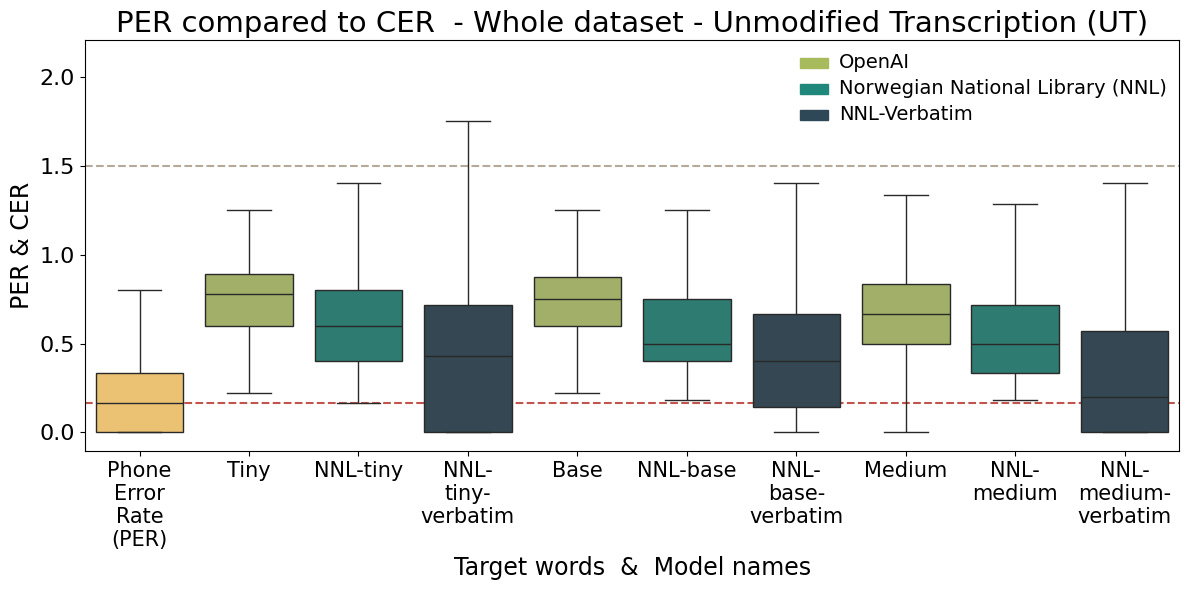

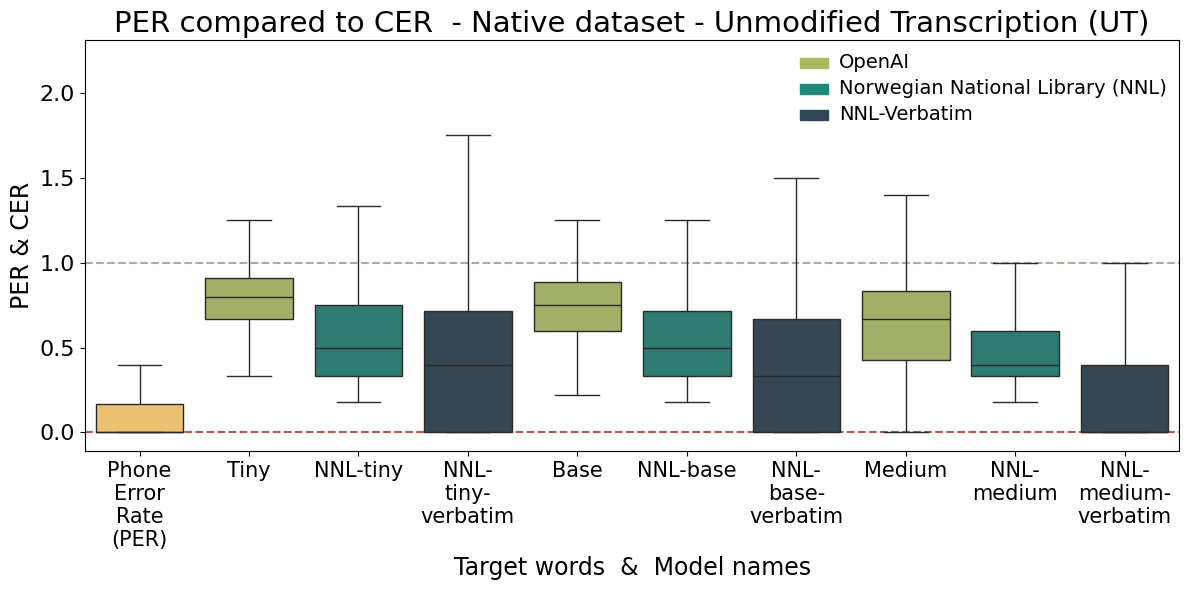

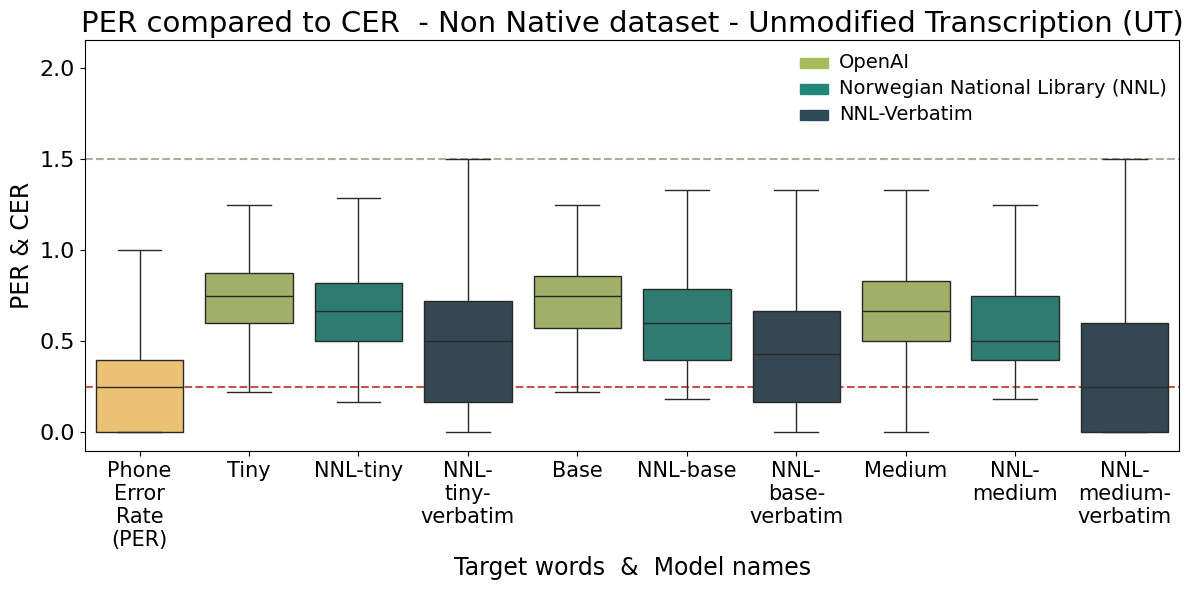

In [10]:
# ------------ All data Box Plot ------------ #
ggm_fix = fix_model_names(ggm)
box_plots_model(ggm_fix, os.path.join(save_dir_box_cer, 'PER_&_CER_All_Models_All_Data_NS.png'), 'Whole dataset',
                cer_name = 'Unmodified Transcription (UT)')

# -------------- Non-Native Box Plot -------------- #
ggm_d = ggm[ggm['id'].str.contains('d')].copy()
ggm_fix_non_native = fix_model_names(ggm_d)
box_plots_model(ggm_fix_non_native, os.path.join(save_dir_box_cer, 'PER_&_CER_All_Models_Native_NS.png'), 
                            title='Native dataset', extended = 2.2, max_verbatim = 1,
                            cer_name = 'Unmodified Transcription (UT)')

# -------------- Non Native Box Plot -------------- #
ggm_a = ggm[ggm['id'].str.contains('a')].copy()
ggm_fix_native = fix_model_names(ggm_a)
box_plots_model(ggm_fix_native, os.path.join(save_dir_box_cer, 'PER_&_CER_All_Models_Non_Native_Data_NS.png'), 
                            title='Non Native dataset', extended = 2.05, max_verbatim = 1.6,
                            cer_name = 'Unmodified Transcription (UT)')

##### <b><span style="color:#FF6F91"> Box plot for all models, all data, native and non-native</span></b> Modified (M) *STRIPED (S)*

In [72]:
# ------------ All data Box Plot ------------ #
ggm_fix_S = fix_model_names(ggm, cer_value='striped_CER')
box_plots_model(ggm_fix_S, os.path.join(save_dir_box_cer, 'PER_&_CER_All_Models_All_Data_S.png'), 
                            title = 'Whole dataset', cer_value = 'striped_CER', cer_name = 'Modified Transcription (MT)',
                            extended = 2, max_verbatim = 1.4)


# -------------- Native Box Plot -------------- #
ggm_d = ggm[ggm['id'].str.contains('d')].copy()
ggm_fix_native_S = fix_model_names(ggm_d, cer_value='striped_CER')
box_plots_model(ggm_fix_native_S, os.path.join(save_dir_box_cer, 'PER_&_CER_All_Models_Native_Data_S.png'), 
                            title='Native dataset', extended = 2.2, max_verbatim = 1,
                            cer_value = 'striped_CER', cer_name = 'Modified Transcription (MT)')

# -------------- Non-Native Box Plot -------------- #
ggm_a = ggm[ggm['id'].str.contains('a')].copy()
ggm_fix_non_native_S = fix_model_names(ggm_a, cer_value='striped_CER')
box_plots_model(ggm_fix_non_native_S, os.path.join(save_dir_box_cer, 'PER_&_CER_All_Models_Non_Native_S.png'), 
                            title='Non Native dataset', extended = 2.1, max_verbatim = 1.6,
                            cer_value = 'striped_CER', cer_name = 'Modified Transcription (MT)')

#### <span style="color:#FFC75F">  Every **ID** compared for best model &nbsp;:&nbsp; CER vs. PER for <b>Native</b>, <b>Non Native</b> and <b>all</b> </span>
Create directory to save the box plots &nbsp; : &nbsp; <span style="color:#F9F871"> *./BoxPlots/Model_CER*</i></span>

##### **<span style="color:#D65DB1"> BOX PLOT function for all ID's comparing PER and CER** ➝ Only use the best model including **<span style="color:#D65DB1"> Modified (M) / Unmodified (U) *Striped/Non Striped*</span>**

In [11]:
def box_plots_id(best_model:pd.DataFrame, save_dir:str, cer:str = 'CER', cer_name:str = 'CER', save:bool = False):
    # ------ Melt model, so PER and CER can be compared ------ #
    df_melted = pd.melt(best_model, id_vars=['id'], value_vars=['PER', cer],
                        var_name='cer_type', value_name='cer_value') 
    df_melted_a = df_melted[df_melted['id'].str.contains('a')].copy() # Non Native
    df_melted_d = df_melted[df_melted['id'].str.contains('d')].copy() # Native 
    
    fig, ax = plt.subplots(1, 1, figsize=(25, 6))
    #  ----------  Boxplot ---------- #
    sns.boxplot(x='id', y='cer_value', hue='cer_type', data=df_melted_a, ax=ax, showfliers=False, palette=['#FFC75F', '#00966E'], linewidth=1.5)
    sns.boxplot(x='id', y='cer_value', hue='cer_type', data=df_melted_d, ax=ax, showfliers=False, palette=['#FFC75F', '#C1554D'], linewidth=1.5)
    
    #  ---------- Title and labels ---------- #
    plt.title(f"PER for target words compared to CER for the different ID's - {cer_name}", fontsize=25)
    plt.xlabel("PER Target words &  CER ID's", fontsize=18)
    plt.ylabel(f'PER & CER', fontsize=18)
    
    #  ---------- x- and y-axis ---------- #
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=16)
    
    #  ---------- Model legend box  ---------- # 
    chosen_colors = ['#FFC75F', '#00966E', '#C1554D']
    chosen_names = ['PER', 'CER Non Native', 'CER Native']
    legend_patches = [mpatches.Patch(color=color, label=name) for name, color in zip(chosen_names, chosen_colors)]

    # Add legend with custom settings
    # legend = ax.legend(handles=legend_patches, loc='upper left', frameon=True, shadow=True)
    legend = ax.legend(handles=legend_patches, loc='upper left', frameon=False, shadow=False)
    legend.get_frame().set_facecolor('#f0eeeb')  # Background color
    # legend.get_title().set_fontsize('16')  # Title font size
    for text in legend.get_texts():
        text.set_fontsize('16')  # Legend text font size
    
    
    #  ---------- Save or Show ---------- #
    plt.tight_layout()
    if save:
        plt.savefig(save_dir)
        plt.close()
    else:
        plt.show()

#### Define the <span style="color:#FF9671">**BEST MODEL**</span>


In [12]:
# -------- BEST MODEL -------- #
model_path = '../Transcriptions/Results/transcriptions_nb-whisper-medium-verbatim_v1.csv'
df_best = pd.read_csv(model_path)
best_color = '#2f4858'

##### <b><span style="color:#FFC75F"> Box plot for all id's and all data</span></b> 'Unmodified (U) *NOT STRIPED (NS)*

In [13]:
box_plots_id(df_best, os.path.join(save_dir_box_cer, 'PER_&_CER_All_IDs_NS.png'), cer='CER', cer_name='Unmodified Transcription (UT)', save=True)

##### <b><span style="color:#FFC75F"> Box plot for all id's and all data</span></b> Modified (M) *STRIPED (S)*

In [14]:
box_plots_id(df_best, os.path.join(save_dir_box_cer, 'PER_&_CER_All_IDs_S.png'), cer='striped_CER', cer_name='Modified Transcription (MT)', save=True)

### <span style="color:#845EC2"> **BOX PLOT** for **Score** groups  and CER / PER </span> ➝ Only use the best model **Unmodified** *NOT STRIPED (NS)*



#### <span style="color:#D65DB1"> Quartile Calcuations: </span>

**Box**: The solid block of the boxplot represents the interquartile range (IQR), which is the range between the first quartile (Q1) and the third quartile (Q3). The ends of the box are:

**Lower end**(bottom of the box): The first quartile (Q1), which is the median of the lower half of the data.

**Upper end** (top of the box): The third quartile (Q3), which is the median of the upper half of the data.

We use the Quartile calculations to determine the global score segments for the transcribed words. This first 2 models uses CER and striped_CER. 
The last plot where all models are plotted together, the PER is used instead of CER.

In [15]:
# # ---------- Calculate the quartiles ---------- #
q1 = df_best.groupby('global_score')['CER'].quantile(0.25)
q3 = df_best.groupby('global_score')['CER'].quantile(0.75)
# print(f"Q1:\n{q1}")
# print(f"Q3:\n{q3}")

#### <span style="color:#FF6F91"> BOX PLOTS: </span>

In [16]:
# ------ Melt model, so PER and CER can be compared ------ #
df_melted_score = pd.melt(df_best, id_vars=['global_score'], value_vars=['PER', 'CER'],
                    var_name='cer_type', value_name='cer_value') 

fig, ax = plt.subplots(1, 1, figsize=(12, 6))
colors = ['#FFC75F', '#2F4858']

# ---------- Horizontal lines ---------- #
score_range = ['#d2e7e4', '#a6cfca', '#63aca2', '#20887a', '#1a6d62']
q1 = df_best.groupby('global_score')['CER'].quantile(0.25)
q3 = df_best.groupby('global_score')['CER'].quantile(0.75)

align = 4.68
for score in range(1, 6):  # Iterate over scores 1 to 5
    if score == 1:
        text_y = q3[1]
        ax.text(align, text_y, f'Score {score}', va='center', ha='center', color=score_range[-1], fontsize=12)
    elif score == 5:
        ax.axhline(q3[score], color='#C1554D', linestyle='--')
        ax.axhline(q1[score], color='#C1554D', linestyle='--')
        ax.axhspan(ymin=q1[score], ymax=q3[score], color=score_range[-1], alpha=0.5)
        
        text_y = (q1[score]+ q3[score])/ 2
        ax.text(align, text_y, f'Score {score}', va='center', ha='center', color=score_range[-1], fontsize=12)
    else:    
        ax.axhline(q3[score], color='#C1554D', linestyle='--')
        ax.axhspan(ymin=q3[score], ymax=q3[score+1], color=score_range[score-1], alpha=0.5)
        
        text_y = (q3[score] + q3[score + 1])/ 2
        ax.text(align, text_y, f'Score {score}', va='center', ha='center', color=score_range[-1], fontsize=12)
        
#  ----------  Boxplot ---------- #
sns.boxplot(x='global_score', y='cer_value', hue='cer_type', data=df_melted_score, ax=ax, showfliers=False, palette=colors, linewidth=1.5)

#  ---------- Model legend box  ---------- # 
chosen_colors = colors
chosen_names = ['PER: Target Words', 'CER: NNL-Verbatim']
legend_patches = [mpatches.Patch(color=color, label=name) for name, color in zip(chosen_names, chosen_colors)]

legend = ax.legend(handles=legend_patches, loc='best', frameon=False, shadow=False)
for text in legend.get_texts():
    text.set_fontsize('11')  # Legend text font size

#  ---------- Title and labels ---------- #
plt.title(f'PER and CER for each score for all models compaired - Unmodified Transcription (MT)', fontsize=17)
plt.xlabel('Global Score', fontsize=14)
plt.ylabel(f'PER & CER', fontsize=14)

#  ---------- Wrap x-axis ---------- # (Wrap method found by ChatGPT) 
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)

# ------- Save or Show ---------- #
plt.tight_layout()

save_dir = os.path.join(save_dir_box_cer, 'Score_per_cer_best_model_all_data_NS.png')
plt.savefig(save_dir)
plt.close()
# plt.show()

### <span style="color:#D65DB1"> **BOX PLOT** same as over but </span>➝ **Modified Transcription (MT)** *STRIPED (S)*

In [17]:
# ------ Melt model, so PER and CER can be compared ------ #
df_melted_score = pd.melt(df_best, id_vars=['global_score'], value_vars=['PER', 'striped_CER'],
                    var_name='cer_type', value_name='cer_value') 


fig, ax = plt.subplots(1, 1, figsize=(12, 6))

# ---------- Horizontal lines ---------- #
score_range = ['#d2e7e4', '#a6cfca', '#63aca2', '#20887a', '#1a6d62']
q1 = df_best.groupby('global_score')['striped_CER'].quantile(0.25)
q3 = df_best.groupby('global_score')['striped_CER'].quantile(0.75)

align = 4.68
for score in range(1, 6):  # Iterate over scores 1 to 5
    if score == 1:
        text_y = q3[1]
        ax.text(align, text_y, f'Score {score}', va='center', ha='center', color=score_range[-1], fontsize=12)
    elif score == 5:
        ax.axhline(q3[score], color='#C1554D', linestyle='--')
        ax.axhline(q1[score], color='#C1554D', linestyle='--')
        ax.axhspan(ymin=q1[score], ymax=q3[score], color=score_range[-1], alpha=0.5)
        
        text_y = (q1[score]+ q3[score])/ 2
        ax.text(align, text_y, f'Score {score}', va='center', ha='center', color=score_range[-1], fontsize=12)
    else:    
        ax.axhline(q3[score], color='#C1554D', linestyle='--')
        ax.axhspan(ymin=q3[score], ymax=q3[score+1], color=score_range[score-1], alpha=0.5)
        
        text_y = (q3[score] + q3[score + 1])/ 2
        ax.text(align, text_y, f'Score {score}', va='center', ha='center', color=score_range[-1], fontsize=12)
        
#  ----------  Boxplot ---------- #
sns.boxplot(x='global_score', y='cer_value', hue='cer_type', data=df_melted_score, ax=ax, showfliers=False, palette=['#FFC75F', best_color], linewidth=1.5)

#  ---------- Model legend box  ---------- # 
chosen_colors = ['#FFC75F', best_color]
chosen_names = ['PER: Target Words', 'CER: NNL-Verbatim']
legend_patches = [mpatches.Patch(color=color, label=name) for name, color in zip(chosen_names, chosen_colors)]

legend = ax.legend(handles=legend_patches, loc='best', frameon=False, shadow=False)
for text in legend.get_texts():
    text.set_fontsize('11')  # Legend text font size

#  ---------- Title and labels ---------- #
plt.title(f'PER and CER for each score for all models compaired - Modified Transcription (MT)', fontsize=17)
plt.xlabel('Global Score', fontsize=14)
plt.ylabel(f'PER & CER', fontsize=14)

#  ---------- Wrap x-axis ---------- # (Wrap method found by ChatGPT) 
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)

# ------- Save or Show ---------- #
plt.tight_layout()

save_dir = os.path.join(save_dir_box_cer, 'Score_per_cer_best_model_all_data_S.png')
plt.savefig(save_dir)
plt.close()
# plt.show()

### <span style="color:#FF6F91"> **BOX PLOT** for **Score** groups  and CER / PER </span> ➝ For all models

In [18]:
ggm_fix = fix_model_names(ggm)

fig, ax = plt.subplots(1, 1, figsize=(12, 6))
# ---------- Color palette  ---------- #
palette = ['#FFC75F', # PER color
            '#A8BB5C', '#20887A', '#2F4858', # Model colors       
            '#A8BB5C', '#20887A', '#2F4858',          
            '#A8BB5C', '#20887A', '#2F4858']

# ---------- Horizontal lines ---------- #
score_range = ['#d2e7e4', '#a6cfca', '#63aca2', '#20887a', '#1a6d62']
q1 = ggm_fix[ggm_fix['model_name']=='Phone Error Rate (PER)'].groupby('global_score')['CER'].quantile(0.25)
q3 = ggm_fix[ggm_fix['model_name']=='Phone Error Rate (PER)'].groupby('global_score')['CER'].quantile(0.75)

align = 4.68
for score in range(1, 6):  # Iterate over scores 1 to 5
    if score == 1:
        text_y = q3[1]
        ax.text(align, text_y, f'Score {score}', va='center', ha='center', color=score_range[-1], fontsize=12)
    elif score == 5:
        ax.axhline(q3[score], color='#C1554D', linestyle='--')
        ax.axhline(q1[score], color='#C1554D', linestyle='--')
        ax.axhspan(ymin=q1[score], ymax=q3[score], color=score_range[-1], alpha=0.5)
        
        text_y = (q1[score]+ q3[score])/ 2
        ax.text(align, text_y, f'Score {score}', va='center', ha='center', color=score_range[-1], fontsize=12)
    else:    
        ax.axhline(q3[score], color='#C1554D', linestyle='--')
        ax.axhspan(ymin=q3[score], ymax=q3[score+1], color=score_range[score-1], alpha=0.5)
        
        text_y = (q3[score] + q3[score + 1])/ 2
        ax.text(align, text_y, f'Score {score}', va='center', ha='center', color=score_range[-1], fontsize=12)
        

#  ----------  Boxplot ---------- #
sns.boxplot(x='global_score', y='CER', hue='model_name', data=ggm_fix, ax=ax, showfliers=False, palette=palette)

#  ---------- Model legend box  ---------- #  (Custom legends found by ChatGPT) 
chosen_colors = ['#FFC75F', '#A8BB5C', '#2F4858', '#20887A']
chosen_names = ['PER', 'OpenAI', 'NNL-Verbatim', 'Norwegian National Library (NNL)']
legend_patches = [mpatches.Patch(color=color, label=name) for name, color in zip(chosen_names, chosen_colors)]


legend = ax.legend(handles=legend_patches, loc='best', frameon=False, shadow=False, ncol = 2)
for text in legend.get_texts():
    text.set_fontsize('11')  # Legend text font size

#  ---------- Title and labels ---------- #
plt.title(f'PER and CER for each score for all models compaired ', fontsize=17)
plt.xlabel('Global Score', fontsize=14)
plt.ylabel(f'PER & CER', fontsize=14)

#  ---------- Wrap x-axis ---------- # (Wrap method found by ChatGPT) 
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)

# ------- Save or Show ---------- #
plt.tight_layout()

save_dir = os.path.join(save_dir_box_cer, 'Score_per_cer_all_models_all_data_NS.png')
plt.savefig(save_dir)
plt.close()
# plt.show()